# Surrogate Ensemble Modeling for Dynamic Climate Impact Models

## Introduction

## Results overview

#### Quantile range

| Model       | Features    | Sequence length | Predicted timestamp | Hit rate    |
| ----------- | ----------- | -----------     |-----------          | ----------- |
| BLSTM       | ['day_of_month', 'month', 'precip', 'temp', 'R0']  | 50 | 51st |  0.686   |
| RFQR        | ['day_of_month', 'month', 'precip', 'temp', 'R0']  | 50 | 51st |  0.376   |
| BLSTM       | ['day_of_month', 'month', 'precip', 'temp']        | 50 | 50th |  0.765   |
| RFQR        | ['day_of_month', 'month', 'precip', 'temp']        | 50 | 50th |  0.589   |
| RFQR        | ['day_of_month', 'month', 'precip', 'temp']        | 1  | 1st  |  0.806   |


#### Ensemble quantile range
| Model       | Features    | Sequence length | Predicted timestamp | Hit rate    |
| ----------- | ----------- | -----------     |-----------          | ----------- |
| BLSTM       | ['day_of_month', 'month', 'precip', 'temp', 'R0']  | 50 | 51st |  0.798 (samples)  |
| BLSTM       | ['day_of_month', 'month', 'precip', 'temp']        | 50 | 50th |  0.862 (samples)  |

## Libraries

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from utils import plotting

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading seaonal forecast ensembles dataset

In [2]:
dataset = 'R0_malaria_model_variables.csv'

In [12]:
df = pd.read_csv('datasets/'+dataset)
df.datetime = pd.to_datetime(df.datetime)
df.head()

,forecast,precip,temp,datetime,year,month,day_of_month,day_of_year,season,P,gono_len,sporo_len,mosquitoes,R0
0,1,0.576628,17.865900,2017-01-01,2017,1,1,1,Spring,0.904054,5.173293,1000.000000,0.0,0.0
1,1,0.166432,18.287195,2018-01-01,2018,1,1,1,Spring,0.902434,4.983980,386.497216,0.0,0.0
2,1,1.760069,19.013910,2019-01-01,2019,1,1,1,Spring,0.898305,4.694860,109.477182,0.0,0.0
3,1,0.000000,16.801691,2020-01-01,2020,1,1,1,Spring,0.905616,5.742562,1000.000000,0.0,0.0
4,1,0.950271,17.495355,2021-01-01,2021,1,1,1,Spring,0.905009,5.355321,1000.000000,0.0,0.0


### Prepare training and testing datasets

In [16]:
split = "split-by-year"
train_ensembles = 0.7

train_years = [2017, 2018, 2019, 2020]
test_years = [2021]

features = ['day_of_month', 'month', 'precip', 'temp']#,'R0']
target   = ['R0']

quantiles = [0.1587, 0.50, 0.8413]
labels = ['R0 lower', 'R0 mean', 'R0 upper']

In [17]:
def scale_data(data, train_years, test_years, features, target):
    
    df_train = data[data['year'].isin(train_years)].copy()
    
    # Fit Scaler only on Training features
    feature_scaler = StandardScaler()
    feature_scaler.fit(df_train[features].values)
    # Fit Scaler only on Training target values
    if target in features:
        target_scaler = StandardScaler()
        target_scaler.fit(df_train[target].values)
    else: 
        target_scaler = None

    # Transfom on both Training and Test data
    data_values = data[features].values.copy()
    data = data.drop(columns=(features))
    data = data.join(pd.DataFrame(feature_scaler.transform(data_values),
                                  columns=features))
    return data, feature_scaler, target_scaler

def select_sliding_data(data, features, target, sequence_length):
    X_list, y_list = [], []
    idxs_selection = pd.Index([])
    for iyear in data['year'].unique():
        data_yearly = data[data['year']==iyear].copy()
        for iseason in data_yearly['season'].unique():
            data_seasonal = data_yearly[data_yearly['season']==iseason].copy()
            for iforecast in data_seasonal['forecast'].unique():
                idata_X = data_seasonal[data_seasonal['forecast']==iforecast][features].values
                idata_y = data_seasonal[data_seasonal['forecast']==iforecast][target].values
                for ii in range(len(idata_X)):
                    if (ii+sequence_length-1) < len(idata_X):              ### if -1: predict for last timestamp in sequence
                        X_list.append(idata_X[ii:ii+sequence_length, :])
                        y_list.append(idata_y[ii+sequence_length-1])       ### if -1: predict for last timestamp in sequence
                idxs_selection = idxs_selection.union(data_seasonal[data_seasonal['forecast']==iforecast].iloc[sequence_length-1:].index, sort=False)
    return(np.array(X_list), np.squeeze(np.array(y_list)), idxs_selection)

In [19]:
df_scaled, feature_scaler, target_scaler = scale_data(df.copy(), train_years, test_years, features, target)

sequence_length = 50

df_train_scaled = df_scaled[df_scaled['year'].isin(train_years)].copy()
df_test_scaled = df_scaled[df_scaled['year'].isin(test_years)].copy()

X_train, y_train, idxs_train = select_sliding_data(df_train_scaled, features, target, sequence_length)
X_test, y_test, idxs_test = select_sliding_data(df_test_scaled, features, target, sequence_length)

df_test = df[['datetime', 'forecast', 'season', 'R0']].iloc[idxs_test].copy()

## BLSTM

In [ ]:
from models.BLSTM import train_blstm
from models.BLSTM import calc_quantiles

In [333]:
## Model parameters
n_features = len(features)
output_length = 1
batch_size = 4096
n_epochs = 200
learning_rate = 0.01
n_experiments = 200
load_model = None #'BLSTM_train2017-2020_predict2021_e200_t0-01_seq50_feat5_bs4096.pth'

In [333]:
## Model training and prediciton with MC dropout
y_pred_blstm_samples = train_blstm(X_train, y_train, X_test, n_features, output_length, batch_size, n_epochs, learning_rate, sequence_length, n_experiments, target_scaler, save_model=True)

Training model ... Epochs: 100%|██████████| 200/200 [14:06:50<00:00, 254.05s/it, loss=0.000908]  


Total time elapsed: 50810.11560153961
Average time per epoch: 254.05057800769805


Monte Carlo Dropout ... Experiments: 100%|██████████| 200/200 [3:06:32<00:00, 55.96s/it]  


In [458]:
## Merge with true values and save dataframe
df_test_blstm_samples = pd.concat([df_test.reset_index(), y_pred_blstm_samples], axis=1) 
df_test_blstm.to_csv('trained_models/blstm_train2017-2020_predict2021_e200_t0-01_seq50_feat4_bs4096_excludeR0_predict50th_n-exp200_'+split+'_samples.csv', index=False)

In [342]:
## Compute quantiles from samples
y_pred_blstm = calc_quantiles(y_pred_blstm_samples, quantiles, labels)

Calculating R0 lower quantile: 0.1587
Calculating R0 mean quantile: 0.5
Calculating R0 upper quantile: 0.8413


In [351]:
## Merge with true values and save dataframe
df_test_blstm = pd.concat([df_test.reset_index(), y_pred_blstm], axis=1) 
df_test_blstm.to_csv('trained_models/blstm_train2017-2020_predict2021_e200_t0-01_seq50_feat4_bs4096_excludeR0_predict50th_n-exp200_'+split+'.csv', index=False)

,index,date,forecast,season,R0,R0 lower,R0 mean,R0 upper
0,249,2021-02-19,1,Spring,1.823343e-01,0.062298,0.065111,0.068248
1,254,2021-02-20,1,Spring,2.175977e-01,0.062587,0.065164,0.067508
2,259,2021-02-21,1,Spring,3.188942e-02,0.056391,0.058855,0.061578
3,264,2021-02-22,1,Spring,2.894879e-01,0.071370,0.074292,0.078108
4,269,2021-02-23,1,Spring,2.904540e-01,0.073576,0.075908,0.078844
...,...,...,...,...,...,...,...,...
13345,91279,2021-12-27,50,Fall,1.018973e-16,0.055202,0.057857,0.060622
13346,91284,2021-12-28,50,Fall,2.613944e-05,0.054999,0.057533,0.060632
13347,91289,2021-12-29,50,Fall,1.349285e-03,0.054939,0.058166,0.060641
13348,91294,2021-12-30,50,Fall,8.935732e-07,0.054317,0.057557,0.060519


## RFQR

In [361]:
from models.RFQR import train_rfqr

In [361]:
## Model parameters
random_state=0
min_samples_split=10
n_estimators=1000
n_jobs=8
verbose=True
load_model_rfqr = 'RFQR_train2017-2020_predict2021_feat4_excludeR0_predict50th.joblib'

In [361]:
## Model training and prediciton of quantiles
y_pred_rfqr = train_rfqr(X_train, y_train, X_test, random_state, min_samples_split, n_estimators, n_jobs, target_scaler, verbose=True, save_model=True, load_model=load_model_rfqr)

Loading model ...
Predicting quantile: R0 lower


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.9s finished


End of predicting quantile: R0 lower
Predicting quantile: R0 mean


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.8s finished


End of predicting quantile: R0 mean
Predicting quantile: R0 upper


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.4s finished


End of predicting quantile: R0 upper


In [363]:
## Merge with true values and save dataframe
df_test_rfqr = pd.concat([df_test.reset_index(), y_pred_rfqr], axis=1) 
df_test_rfqr.to_csv('trained_models/rfqr_train2017-2020_predict2021_e200_t0-01_seq50_feat4_bs4096_excludeR0_predict50th_n-exp200_'+split+'.csv', index=False)

# Result visualization

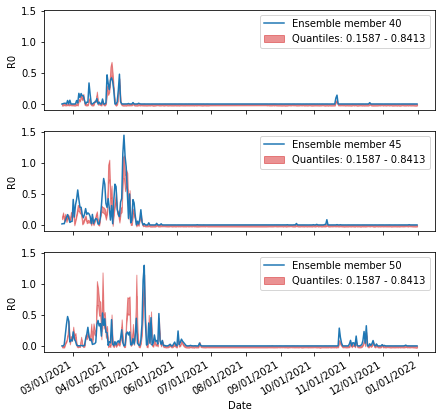

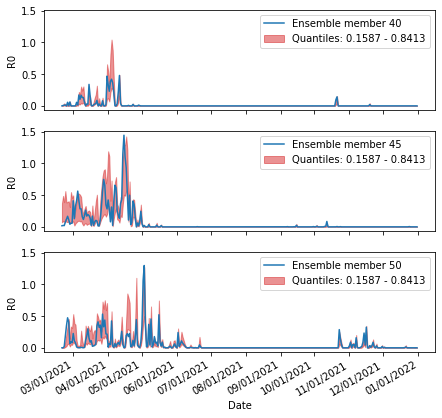

In [449]:
iforecasts = [40, 45, 50]
fig = plotting.plot_single_members(df_test_blstm, iforecasts, 'figures/blstm_2017-2021_iforecast_excR0.pdf')
fig = plotting.plot_single_members(df_test_rfqr, iforecasts, 'figures/rfqr_2017-2021_iforecast_excR0.pdf')

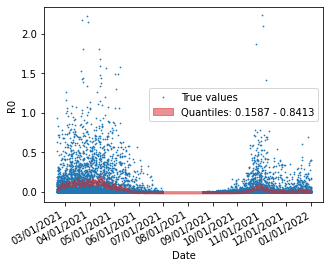

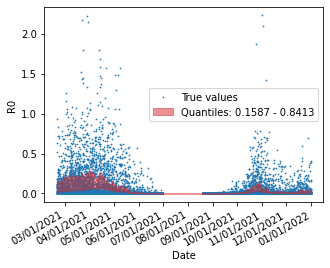

In [461]:
plotting.aggregate_ensembles(df_test_blstm, 'figures/blstm_2021_agg_excR0.pdf')
plotting.aggregate_ensembles(df_test_rfqr, 'figures/rfqr_2021_agg_excR0.pdf')

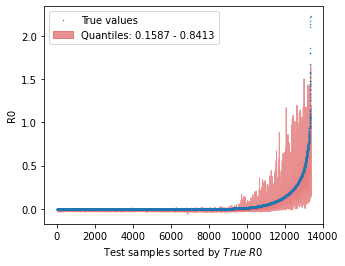

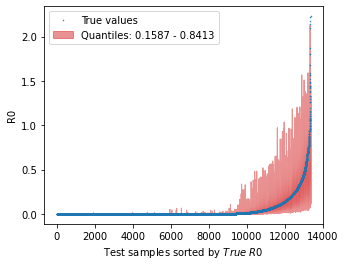

In [462]:
plotting.plot_true_in_interval(df_test_blstm, 'R0', 'figures/blstm_2017-2021_interval_excR0.pdf');
plotting.plot_true_in_interval(df_test_rfqr, 'R0', 'figures/rfqr_2017-2021_interval_excR0.pdf');

In [464]:
print('BLSTM hit rate: ', plotting.hit_rate(df_test_blstm, 'R0', 'R0 upper', 'R0 lower'))
print('RFQR hit rate: ',  plotting.hit_rate(df_test_rfqr, 'R0', 'R0 upper', 'R0 lower'))

BLSTM hit rate:  0.7653932584269663
RFQR hit rate:  0.5892883895131086


### Ensemble quantile range

              date variable     Value
0       2021-02-19     R0_0  0.020719
1       2021-02-20     R0_0  0.078950
2       2021-02-21     R0_0 -0.017875
3       2021-02-22     R0_0  0.105142
4       2021-02-23     R0_0  0.084845
...            ...      ...       ...
2669995 2021-12-27   R0_199 -0.010029
2669996 2021-12-28   R0_199 -0.022107
2669997 2021-12-29   R0_199 -0.038377
2669998 2021-12-30   R0_199  0.010378
2669999 2021-12-31   R0_199 -0.021744

[2670000 rows x 3 columns]
0.8620224719101124


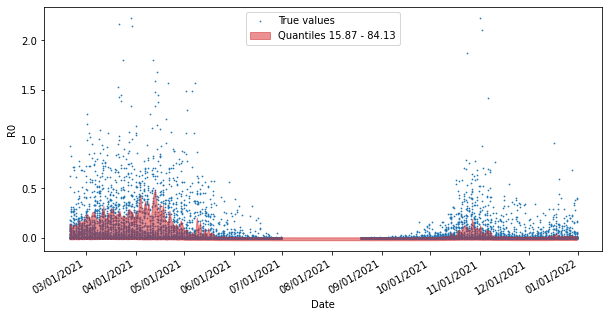

In [457]:
plotting.aggregate_ensembles_samples(df_test_blstm_samples, 'figures/blstm_2021_agg_samples_excR0.pdf')